<a href="https://colab.research.google.com/github/PLEX-GR00T/Cart_Pole_LQR/blob/main/Kalman_Gain_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
from numpy.linalg import inv
import numpy as np
import pandas as pd
import random

In [2]:
M = 1
m = 0.3
b = 0.1
l = 1
I = 0.001
g = 9.8

A = (I + (m*(l**2)))
B = (I*(M+m) + (M*m*(l)**2))
C = ((m**2)*g*(l**2))
D = (-m*l*b)
E = ((m*g*l)*(M+m))
f = (m*l)

AA = -A*b/B
BB = C/B
CC = D/B
DD = E/B

EE = A/B
FF = f/B

N = 1000

dt = 0.01

In [3]:
Tb = np.array([
            [0, 1,  0,  0],
            [0, AA, BB, 0],
            [0, 0,  0,  1],
            [0, CC, DD, 0]]) 

Ta = np.array([[0], 
              [EE], 
              [0], 
              [FF]]) *dt

Identity = np.identity(4, dtype = float)
Ts = Identity + (Tb) * dt

Ra = -2
rho = 10
sigma_noise_val = 0.01
Rs = -np.array([[rho/20, 0, 0, 0],
                [0, rho/20, 0, 0],
                [0, 0, rho, 0],
                [0, 0, 0, rho/10]])

In [4]:
sigma_noise_matrix = np.identity(4) * sigma_noise_val

v = dict()
q = dict()

v[N] = Rs
q[N] = 0

L = dict() # 1 to 1001

In [5]:
for i in range(N, 1, -1):
  v[i-1] = Rs + (Ts.T @ v[i].T @ Ts) - ((Ta.T @ v[i] @ Ts).T) * (inv(Ra + Ta.T @ v[i] @ Ta)) @ (Ta.T @ v[i] @ Ts)
  q[i-1] = q[i] + np.trace(sigma_noise_matrix @ v[i])

for i in range(1, N+1, 1):
    L[i] = ((Ra + Ta.T @ v[i] @ Ta)**(-1)) @ (Ta.T @ v[i] @ Ts)

In [6]:
sd_v = 0.0321
V_ = np.identity(2) * sd_v
sd_w = 0.0123
W_ = np.identity(4) * sd_w

# sensor matrix : 
C_ = np.array([
            [0, 1, 0, 0],            
            [0, 0, 0, 1]])
# C_ = np.identity(4)

Sigma = dict()
Sigma[0] = np.identity(4) * 0.01

X = dict()
X[0] = np.array([[0.1], 
                [-0.05], 
                [0.1], 
                [0.01]])
F = dict()

K = dict()

norm_list = dict()

In [7]:
# Z = []
# def step(n):
    
#     global Z
    
#     if n == 0:
#       Z = X[0]
      
#     Z = Ts @ Z + Ta @ (-L[n+1] @ Z) #+ Wk
#     Y = C_ @ Z #+ Vk
#     return Y

In [8]:
sk_plus_1 = X[0]

def step(n, sk_plus_1):
    sk_plus_1 = Ts @ sk_plus_1 + Ta @ (-L[n+1] @ sk_plus_1) #+ np.random.multivariate_normal([0,0,0,0], W_).reshape(4,1)
    yk_plus_1 = C_ @ sk_plus_1 #+ np.random.multivariate_normal([0,0], V_).reshape(2,1)
    return sk_plus_1, yk_plus_1

In [9]:
for i in range(1,N,1):
    Sigma[i] = W_ + (Ts @ Sigma[i-1] @ Ts.T) - (Ts @ Sigma[i-1] @ C_.T) @ (inv(V_ + C_ @ Sigma[i-1] @ C_.T)) @ (C_ @ Sigma[i-1] @ Ts.T)
  
for i in range(1,N+1,1):
    K[i] = (Ts @ Sigma[i-1] @ C_.T) @ (inv(V_ + C_ @ Sigma[i-1] @ C_.T))

    sk_plus_1, yk_plus_1 = step(i-1,sk_plus_1)
    norm_list[i] = np.linalg.norm(yk_plus_1 - C_ @ X[i-1])

    X[i] = (Ts @ X[i-1]) + (K[i] @ (yk_plus_1 - C_ @ X[i-1]))
    F[i] = -(L[i] @ X[i])

##Q1. Ø1 (the estimated angle) as a function of time.

##Q2. Ø2 (the estimated angular velocity) as a function of time.

## Q3. $||(y_k - C(\hat{s}_k))||_2^2$ as a function of time.

Text(0.5, 1.0, '$||(y_k - C(\\hat{s}_k))||_2^2$ v/s Time')

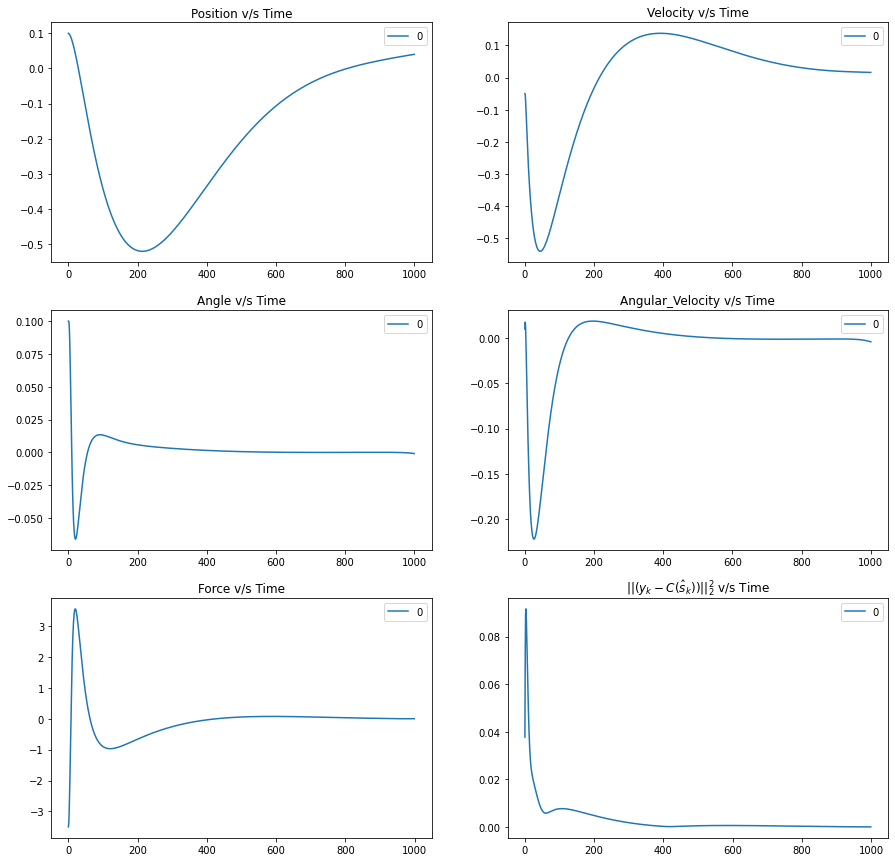

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
pd.DataFrame([float(X[i][0]) for i in X]).plot(ax=axes[0,0]); axes[0,0].set_title('Position v/s Time')
pd.DataFrame([float(X[i][1]) for i in X]).plot(ax=axes[0,1]); axes[0,1].set_title('Velocity v/s Time')
pd.DataFrame([float(X[i][2]) for i in X]).plot(ax=axes[1,0]); axes[1,0].set_title('Angle v/s Time')
pd.DataFrame([float(X[i][3]) for i in X]).plot(ax=axes[1,1]); axes[1,1].set_title('Angular_Velocity v/s Time')
pd.DataFrame([float(F[i])for i in F]).plot(ax=axes[2,0]); axes[2,0].set_title('Force v/s Time')
pd.DataFrame([float(norm_list[i])for i in norm_list]).plot(ax=axes[2,1]); axes[2,1].set_title('$||(y_k - C(\hat{s}_k))||_2^2$ v/s Time')

## 4. Kalman gain at the final step

In [11]:
print(K[N])

[[9.99129965e-03 2.01135565e-06]
 [4.61500719e-01 2.56722719e-02]
 [9.70769721e-02 4.28793465e-01]
 [2.51243607e-02 5.68532963e-01]]


## 5. Control Gain (L) at first step

In [12]:
print(L[1])

[[-0.48036228 -1.59559945 32.91306634  9.56227   ]]
